In [1]:
import os
import sys
from optparse import OptionParser
import re
import gensim
import numpy as np
import pandas as pd
from pprint import pprint
import pandas

import file_handling as fh
from scholar import Scholar
import string

from collections import Counter
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


# compile some regexes
punct_chars = list(set(string.punctuation) - set("'"))
punct_chars.sort()
punctuation = ''.join(punct_chars)
replace = re.compile('[%s]' % re.escape(punctuation))
alpha = re.compile('^[a-zA-Z_]+$')
alpha_or_num = re.compile('^[a-zA-Z_]+|[0-9_]+$')
alphanum = re.compile('^[a-zA-Z0-9_]+$')


In [2]:
stopword_list = fh.read_text(os.path.join('stopwords', 'nl_stopwords.txt'))
stopword_set = {s.strip() for s in stopword_list}
# stopword_set = set([])

In [125]:
train_items = fh.read_jsonlist('data/kinderwens/all.jsonlist')
data = pd.DataFrame(train_items)

In [126]:
data

,certainty,id,intention,maternity,positivity,text,text1,text2
0,True,800100.0,Zeker wel,True,True,Studeren werken en een goed sparen huis verbou...,Studeren werken en een goed sparen huis verbou...,Geen haast Rustig aan Genieten
1,True,800274.0,Zeker niet,True,False,ik ben al over de leeftijd van kinderen heen i...,ik ben al over de leeftijd van kinderen heen,"ik ben te oud, en vind kleine kinderen niet leuk"
2,True,800561.0,Zeker wel,False,True,De wens is er zeker. Er bestaat echter de kans...,De wens is er zeker. Er bestaat echter de kans...,Ik weet heel zeker dat ik kinderen wil. Zeker...
3,False,800573.0,Weet het niet,False,False,Ik verwacht over 3-7 jaar kinderen te krijgen....,Ik verwacht over 3-7 jaar kinderen te krijgen....,"Momenteel leeftijd, daarbij spelen ook stabili..."
4,True,800909.0,Zeker niet,True,False,Ik ben 42 en vind kinderen voldoende,Ik ben 42 en vind kinderen voldoende,Nee
...,...,...,...,...,...,...,...,...
422,True,898834.0,Zeker wel,False,True,Ik wil heel graag kinderen krijgen. Ik zie mij...,Ik wil heel graag kinderen krijgen. Ik zie mij...,Ik denk dat ik het goed kan en een liefdevolle...
423,True,899121.0,Zeker niet,True,False,Deze zijn genoeg voor mij,Deze zijn genoeg voor mij,Omdat ik het zeg
424,True,899359.0,Zeker niet,False,False,Wat me er zeker van maakt dat ik geen kinderen...,Wat me er zeker van maakt dat ik geen kinderen...,"ervaring, tijd, veranwoordelijkheid"
425,True,899383.0,Zeker niet,True,False,ik ben heel blij met 2 gezonde kinderen e dat ...,ik ben heel blij met 2 gezonde kinderen e dat ...,geen enkele: blij met wat ik heb


In [127]:
docs = data['text']
docs1 = data['text1']


In [128]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.


# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]


# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs1[idx] = docs1[idx].lower()  # Convert to lowercase.
    docs1[idx] = tokenizer.tokenize(docs1[idx])  # Split into words.


# Remove words that are only one character.
docs1 = [[token for token in doc if len(token) > 1] for doc in docs1]

/var/folders/9g/6_2hb2v11fz81zk8dfnjwg9m0000gn/T/ipykernel_12766/2333195295.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs[idx] = docs[idx].lower()  # Convert to lowercase.
/var/folders/9g/6_2hb2v11fz81zk8dfnjwg9m0000gn/T/ipykernel_12766/2333195295.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
/var/folders/9g/6_2hb2v11fz81zk8dfnjwg9m0000gn/T/ipykernel_12766/2333195295.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [129]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=2)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            
bigram = Phrases(docs, min_count=2)
for idx in range(len(docs1)):
    for token in bigram[docs1[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs1[idx].append(token)

In [130]:
docs = [[w for w in t if w not in stopword_set] for t in docs]
docs

[['studeren',
  'werken',
  'goed',
  'sparen',
  'huis',
  'verbouwen',
  'kind',
  'geven',
  'nodig',
  'kinderen',
  'beginnen',
  'genieten',
  'kleine',
  'reis',
  'gaan',
  'mooie',
  'wereld',
  'zien',
  'kinderen',
  'krijgen',
  'haast',
  'jongen',
  'kleine',
  'jongen',
  'leuk',
  'aandacht',
  'lieve',
  'jongen',
  'haast',
  'rustig',
  'genieten',
  'nodig_heeft',
  'dan_pas',
  'genieten_van',
  'een_beetje',
  'te_zien'],
 ['leeftijd',
  'kinderen',
  'heen',
  'oud',
  'vind',
  'kleine',
  'kinderen',
  'leuk',
  'te_oud'],
 ['wens',
  'bestaat',
  'kans',
  'kinderen',
  'krijgen',
  'partner',
  'ivf',
  'traject',
  'dergelijke',
  'weet',
  'kinderen',
  'gezien',
  'leeftijd',
  'leeftijdsgenoten',
  'kinderen',
  'krijgen',
  'begint',
  'kriebelen',
  'de_kans',
  'steeds_meer',
  'steeds_meer'],
 ['verwacht',
  'jaar',
  'kinderen',
  'krijgen',
  'afhankelijk',
  'leven',
  'loopt',
  'jaar',
  'momenteel',
  'leeftijd',
  'daarbij',
  'spelen',
  'stab

In [101]:
docs1 = [[w for w in t if w not in stopword_set] for t in docs1]
docs1

[['studeren',
  'werken',
  'goed',
  'sparen',
  'huis',
  'verbouwen',
  'kind',
  'geven',
  'nodig',
  'kinderen',
  'beginnen',
  'genieten',
  'kleine',
  'reis',
  'gaan',
  'mooie',
  'wereld',
  'zien',
  'kinderen',
  'krijgen',
  'haast',
  'jongen',
  'kleine',
  'jongen',
  'leuk',
  'aandacht',
  'lieve',
  'jongen',
  'nodig_heeft',
  'dan_pas',
  'genieten_van',
  'een_beetje',
  'te_zien'],
 ['leeftijd', 'kinderen', 'heen'],
 ['wens',
  'bestaat',
  'kans',
  'kinderen',
  'krijgen',
  'partner',
  'ivf',
  'traject',
  'dergelijke',
  'de_kans'],
 ['verwacht',
  'jaar',
  'kinderen',
  'krijgen',
  'afhankelijk',
  'leven',
  'loopt',
  'jaar',
  'te_krijgen'],
 ['42', 'vind', 'kinderen', 'voldoende'],
 ['onduidelijk'],
 ['kinderen', 'krijgen', 'eileiders', 'kanker', 'gen', 'verwijderd'],
 ['gezonde',
  'kinderen',
  'jaar',
  '35',
  'jaar',
  'ouder',
  '36',
  'jaar',
  'zwanger',
  'raken',
  'ivm',
  'eventuele',
  'risico',
  'daarnaast',
  'kinderen',
  'bieden

In [131]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary1 = Dictionary(docs1)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=2, no_above=0.5)
dictionary1.filter_extremes(no_below=2, no_above=0.5)

In [132]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
tfidf_model = gensim.models.TfidfModel(corpus)
tfidf_corpus = tfidf_model[corpus]

corpus1 = [dictionary1.doc2bow(doc) for doc in docs1]
tfidf_model1 = gensim.models.TfidfModel(corpus1)
tfidf_corpus1 = tfidf_model[corpus1]

In [133]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 933
Number of documents: 427


In [111]:
print('Number of unique tokens: %d' % len(dictionary1))
print('Number of documents: %d' % len(corpus1))

Number of unique tokens: 730
Number of documents: 427


In [134]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
def run_lda(n):
    num_topics = n
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=tfidf_corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
    )
    return model

In [113]:
def run_lda_q1(n):
    num_topics = n
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary1[0]  # This is only to "load" the dictionary.
    id2word = dictionary1.id2token

    model = LdaModel(
        corpus=tfidf_corpus1,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
    )
    return model

In [135]:
import pyLDAvis
import pyLDAvis.gensim_models

model = run_lda(5)
LDAvis_prepared = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

/usr/local/anaconda3/envs/scholar/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [136]:
pyLDAvis.display(LDAvis_prepared)

In [64]:
for t in model.show_topics(formatted=False, num_words=30):
    print([i[0] for i in t[1]])


['een_kind', 'partner', 'op_dit', 'geen_partner', 'graag', 'wil_graag', 'kinderwens', 'relatie', 'kind', 'vaste', 'momenteel', 'jaar', 'krijgen', 'studie', 'huis', 'geen_kinderwens', 'komende', 'de_komende', 'goede', 'moment', 'tijd', 'jong', 'vriend', 'leeftijd', 'reizen', 'stabiel', 'goed', 'gezondheid', 'een_kind_een_kind', 'geen_vaste']
['een_kind', 'voldoende', 'kind', 'leven', 'situatie', 'lukt', 'goed', 'krijgen', 'wereld', 'weet', 'gebeuren', 'vind', 'brengen', 'lijkt_me', 'jaar', 'de_wereld', 'zorgen', 'gezond', 'graag', 'toekomst', 'partner', 'het_lijkt', 'vinden', 'te_brengen', 'we_hebben', 'beginnen', '42', 'te_klein', 'weet_niet', 'opvoeding']
['op_dit', 'een_kind', 'weet', 'krijgen', 'partner', 'vind', 'leeftijd', 'graag', 'staat', '40', 'voor_ons', 'heel_graag', 'baarmoeder', 'moment', 'kind', 'gaat', 'relatie', 'redenen', 'denk', 'de_vraag', 'planning', 'medische', 'weet_niet', 'laten', 'oud', 'bang', 'lukken', 'vraag', 'hou', 'zwanger']
['geen_behoefte', 'behoefte', 'p

In [77]:
import numpy as np
import codecs
import json

def coherence(model, ref_vocab, ref_counts):
    topics = []
    for t in model.show_topics(formatted=False, num_words=30):
        topic = []
        for w in t[1]:
            if '_' not in w[0]:
                topic.append(w[0])
#         print(topic)
        topics.append(topic)

    ref_vocab = read_json(ref_vocab)
    ref_counts = load_sparse(ref_counts).tocsc()
    coherence_score = compute_npmi_at_n(topics, ref_vocab, ref_counts)
    return coherence_score

def compute_npmi_at_n(topics, ref_vocab, ref_counts, n=10, cols_to_skip=0):

    vocab_index = dict(zip(ref_vocab, range(len(ref_vocab))))
    n_docs, _ = ref_counts.shape

    npmi_means = []
    for topic in topics:
        words = topic[cols_to_skip:]
        npmi_vals = []
        for word_i, word1 in enumerate(words[:n]):
            if word1 in vocab_index:
                index1 = vocab_index[word1]
            else:
                index1 = None
            for word2 in words[word_i+1:n]:
                if word2 in vocab_index:
                    index2 = vocab_index[word2]
                else:
                    index2 = None
                if index1 is None or index2 is None:
                    npmi = 0.0
                else:
                    col1 = np.array(ref_counts[:, index1].todense() > 0, dtype=int)
                    col2 = np.array(ref_counts[:, index2].todense() > 0, dtype=int)
                    c1 = col1.sum()
                    c2 = col2.sum()
                    c12 = np.sum(col1 * col2)
                    if c12 == 0:
                        npmi = 0.0
                    else:
                        npmi = (np.log10(n_docs) + np.log10(c12) - np.log10(c1) - np.log10(c2)) / (np.log10(n_docs) - np.log10(c12))
                npmi_vals.append(npmi)
        print(str(np.mean(npmi_vals)) + ': ' + ' '.join(words[:n]))
        npmi_means.append(np.mean(npmi_vals))
    print(np.mean(npmi_means))
    return np.mean(npmi_means)

def read_json(input_filename):
    with codecs.open(input_filename, 'r', encoding='utf-8') as input_file:
        data = json.load(input_file)
    return data

from scipy import sparse

def load_sparse(input_filename):
    npy = np.load(input_filename)
    coo_matrix = sparse.coo_matrix((npy['data'], (npy['row'], npy['col'])), shape=npy['shape'])
    return coo_matrix.tocsc()


In [89]:
kw_cs = []
zw_cs = []

for i in range(4, 11):
    m = run_lda(i)
    kw_cs.append(coherence(m, 
          'viva-kinderwens/ref_counts.vocab.json',
          'viva-kinderwens/ref_counts.npz'))
    zw_cs.append(coherence(m, 
          'viva-zwanger/ref_counts.vocab.json',
          'viva-zwanger/ref_counts.npz'))

0.1374569682445881: leeftijd voldoende oud graag kind vind partner jaar vinden relatie
0.15499420943874687: partner graag weet jaar relatie krijgen kind vaste leven goed
0.13118066939935974: krijgen kind wereld partner mooi gezondheid weet mensen gaan denk
0.10308401511289934: leeftijd kinderwens compleet gezin behoefte krijgen vind tijd geld oud
0.13167896554889852
0.14591912340723512: leeftijd voldoende oud graag kind vind partner jaar vinden relatie
0.148178920113377: partner graag weet jaar relatie krijgen kind vaste leven goed
0.12332214065799549: krijgen kind wereld partner mooi gezondheid weet mensen gaan denk
0.14356947698425285: leeftijd kinderwens compleet gezin behoefte krijgen vind tijd geld oud
0.1402474152907151
0.08697900679481155: geld single leeftijd weet voldoende krijgen tijd vind planning inkomen
0.15696351931719: oud leeftijd kind graag goed gezondheid krijgen partner vind relatie
0.08457347599670387: partner krijgen kinderwens jaar weet kind medische zwanger graag

0.12862324138283285: behoefte voldoende oud goede opleiding prima dochter leeftijd keuze vind
0.14762456380282118: kind krijgen leven jaar weet tijd graag partner goed toekomst
0.1186631300918508: voldoende gezin aspecten moeder specifieke graag vind juiste partner kinderwens
0.10926572536381599: vinden moment partner inkomen leeftijd corona medische gezondheid vast onzekerheden
0.08711994414272742: carrière geld wereld weet nodig graag zorgen leeftijd energie kind
0.0779730155191263: studie erfelijkheid partner financiën redenen hou situatie kleine leuk woon
0.13939974508193237: kinderwens partner kind gezonde krijgen ivf studie gezin biologische kosten
0.10294492912760271: lukken mee weet gebeuren slapen gaat kinderwens jongens goed gelukkig
0.14091986966298853: relatie graag vaste werk vind man vraag leeftijd partner groter
0.09388963496142247: leeftijd oud man baarmoeder gelukkig 40 krijgen 41 blij tijd
0.11464237991371207


Unable to revert mtime: /Library/Fonts
Fontconfig warning: ignoring UTF-8: not a valid region tag


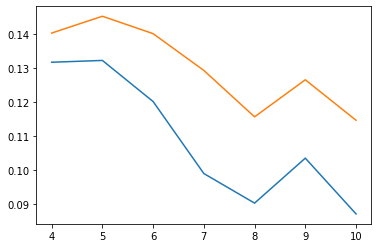

In [107]:
from matplotlib import pyplot

pyplot.plot(list(range(4,11)),list(zip(kw_cs, zw_cs)))

In [118]:
kw_cs1 = []
zw_cs1 = []

for i in range(4, 11):
    m = run_lda_q1(i)
    kw_cs1.append(coherence(m, 
          'viva-kinderwens/ref_counts.vocab.json',
          'viva-kinderwens/ref_counts.npz'))
    zw_cs1.append(coherence(m, 
          'viva-zwanger/ref_counts.vocab.json',
          'viva-zwanger/ref_counts.npz'))

0.06688637805473178: kinderwens man gebeuren snel vaste tevreden chronische twijfelen lang gegund
0.08172103619888244: jaar 40 krijgen situatie 42 oud kinderwens partner echt vind
0.06459957482298706: leeftijd compleet gezin prima blij baarmoeder lukt 43 rol speelt
0.15507701996103768: krijgen vind jaar relatie tijd weet graag mee moment vinden
0.09207100225940974
0.099139886368094: kinderwens man gebeuren snel vaste tevreden chronische twijfelen lang gegund
0.08604836246764032: jaar 40 krijgen situatie 42 oud kinderwens partner echt vind
0.11323214692876596: leeftijd compleet gezin prima blij baarmoeder lukt 43 rol speelt
0.1471867792999714: krijgen vind jaar relatie tijd weet graag mee moment vinden
0.11140179376611792
0.07389991633844978: compleet 40 jaar weet leeftijd gezin vriend gezien gezonde krijgen
0.0666716348912526: vind gelukkig voldoende vinden 42 mee geld keer zwangerschap jongste
0.15027072397810706: krijgen jaar relatie tijd vind moment graag huis oud echt
0.06817650360

0.12723786562710032: weet blij kinderwens jaar krijgen goed gaan mee gebeurt bang
0.1097715165885818: leeftijd oud krijgen 40 vind keuze kinderwens zie compleet echt
0.12263784553411967


ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

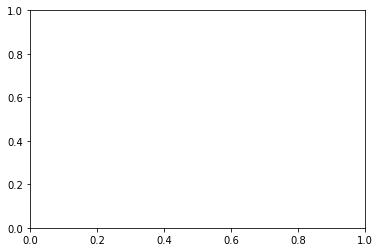

In [115]:
from matplotlib import pyplot

pyplot.plot(list(range(4,11)),list(zip(kw_cs1, zw_cs1)))